# Data collection

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns


In [18]:
def loggg(with_dataframe=False):
    def decorator(f):

        if with_dataframe == True:

            def wrapper(dataf, *args, **kwargs):
                import datetime as dt

                tic = dt.datetime.now()  # Время начала выполнения функции
                result = f(dataf, *args, **kwargs)  # Выполнения функции
                toc = dt.datetime.now()  # Время окончания работы функции

                # Если у dataf и result есть аттрибут shape, то добавляются названия колонн и делается заптсь об изменении shape
                if hasattr(dataf, "shape") and hasattr(result, "shape"):
                    share_before = dataf.shape
                    shape_after = result.shape
                    added_columns = set(result.columns) - set(dataf.columns)
                    print(
                        f"{f.__name__},  shape {dataf.shape}->{result.shape},  took={toc-tic}"
                    )

                else:
                    print(f"{f.__name__} took={toc-tic}")

                return result

        else:

            def wrapper(*args, **kwargs):
                import datetime as dt

                tic = dt.datetime.now()  # Время начала выполнения функции
                result = f(*args, **kwargs)  # Выполнения функции
                toc = dt.datetime.now()  # Время окончания работы функции

                # Если у dataf и result есть аттрибут shape, то добавляются названия колонн и делается заптсь об изменении shape
                if hasattr(result, "shape"):
                    shape_after = result.shape
                    print(
                        f"{f.__name__},  result_shape={result.shape},  took={toc-tic}"
                    )

                else:
                    print(f"{f.__name__} took={toc-tic}")

                return result

        return wrapper

    return decorator

## Reading from JSON

In [19]:
def read_from_json(filename):
    import json

    with open(filename) as fin:
        d = json.load(fin)

        proba = d["prediction"]
        yv = d["true_labels"]
        time = d["time_for_prediction"]

    return proba, yv, time


In [20]:
@loggg(with_dataframe=False)
def predictions_from_folder(path, pdb):
    import pandas as pd
    import os
    import datetime as dt

    d = {
        "model": [],
        "type": [],
        "top_threshold": [],
        "train_size": [],
        "probas": [],
        "true_labels": [],
        "time": [],
    }

    for (
        path,
        folders,
        files,
    ) in os.walk(path):
        if path.endswith(pdb):
            for file in files:
                if "json" in os.path.splitext(file)[1]:
                    # print(file)

                    probas, true_labs, time = read_from_json(f"{path}/{file}")

                    model_name = file.split("_")[0].split("=")[1]
                    # More universal way to split regressors & classifiers is needed
                    if model_name.find("Classifier") == -1:
                        d["type"].append("regressor")
                    else:
                        d["type"].append("classifier")
                    d["model"].append(model_name)
                    d["top_threshold"].append(file.split("_")[2].split("=")[1])
                    d["train_size"].append(int(file.split("_")[1].split("=")[1]))
                    d["probas"].append(probas)
                    d["true_labels"].append(true_labs)
                    d["time"].append(
                        dt.timedelta(
                            days=time[0], seconds=time[1], microseconds=time[2]
                        )
                    )
                    # d['time'].append(time)

    #     models = sorted(set(d['model']))
    #     train_sizes = sorted([int(size) for size in set(d['train_size'])])
    #     columns = set(d['top_threshold'])

    df = pd.DataFrame(d)

    return df


## Regressors data modification

In [21]:
def score_to_class(array, pos: int):

    threshold = sorted(array)[pos]
    labels = list(map(lambda x: int(x < threshold), array))
    return labels

In [22]:
@loggg(with_dataframe=True)
def regressor_data_labeling(df):

    import pandas as pd
    import numpy as np

    percentage = np.array(
        [float(item.split()[1][:-2]) / 100 for item in df.top_threshold]
    )
    length = np.array([len(item) for item in df.probas])
    position = np.rint(percentage * length).astype(int)

    df["predicted_labels"] = [
        score_to_class(array, pos) for array, pos in zip(df.probas, position)
    ]
    df["true_labels"] = [
        score_to_class(array, pos) for array, pos in zip(df.true_scores, position)
    ]

    return df

## Classifiers data modification

In [23]:
@loggg(with_dataframe=True)
def add_predicted_labels(df):
    import pandas as pd

    predicted_labels = []

    for _, row in df.iterrows():
        probas = row.probas
        ypred = [0 if s[0] > 0.5 else 1 for s in probas]
        predicted_labels.append(ypred)

    df["predicted_labels"] = pd.Series(predicted_labels)

    return df

## Metrics calculation

In [24]:
@loggg(with_dataframe=True)
def calc_score(df):

    A = df.predicted_labels.values
    B = df.true_labels.values
    C = df.train_size.values

    positive = np.array([np.sum(b) for b in B])
    pred_positive = np.array([np.sum(a) for a in A])
    true_positive = np.array(
        [np.sum((np.array(a)) & (np.array(b))) for a, b in zip(A, B)]
    )
    train_size = np.array([])

    df["accuracy_score"] = [
        np.mean((np.array(a) & np.array(b)) + ((1 - np.array(a)) & (1 - np.array(b))))
        for a, b in zip(A, B)
    ]

    df["recall_score"] = true_positive / positive

    df["precision_score"] = true_positive / pred_positive

    df["docked"] = C + pred_positive

    return df

In [28]:
inputpath = "/storage/margaritakovaleva/2022-07-22_tables"
pdb = "4eiy"

In [29]:
import os

df_models = {}

for entry in os.scandir(inputpath):
    if (entry.is_dir()) and (not entry.name.startswith(".")):
        print(entry.name)
        df_models[entry.name] = predictions_from_folder(entry.path, pdb=pdb)

4eiy
predictions_from_folder,  result_shape=(0, 7),  took=0:00:00.111159
5zty
predictions_from_folder,  result_shape=(0, 7),  took=0:00:00.016803


In [16]:
df_models_regressors = {}
for key in df_models.keys():
    print(key)
    df_models_regressors[key] = (
        df_models[key]
        .query('type == "regressor"')
        .reset_index(drop=True)
        .rename(columns={"true_labels": "true_scores"})
        .pipe(regressor_data_labeling)
    )

4eiy
regressor_data_labeling,  shape (0, 9)->(0, 9),  took=0:00:00.000894
5zty
regressor_data_labeling,  shape (0, 9)->(0, 9),  took=0:00:00.000723


In [58]:
df_models_classifiers = {}
for key in df_models.keys():
    print(key)
    df_models_classifiers[key] = (
        df_models[key]
        .query('type == "classifier"')
        .reset_index(drop=True)
        .pipe(add_predicted_labels)
    )

Morgan_size=4096_radius=2_uncut
add_predicted_labels,  shape (0, 8)->(0, 8),  took=0:00:00.001046
AP_size=2048_uncut


<ipython-input-6-4f82cdacabc1>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['predicted_labels'] = pd.Series(predicted_labels)


add_predicted_labels,  shape (359, 8)->(359, 8),  took=0:00:01.333315
Morgan_size=2048_radius=2_uncut
add_predicted_labels,  shape (0, 8)->(0, 8),  took=0:00:00.000660
Morgan_size=2048_radius=2
add_predicted_labels,  shape (801, 8)->(801, 8),  took=0:00:02.711790
Morgan_size=2048_radius=3_uncut
add_predicted_labels,  shape (0, 8)->(0, 8),  took=0:00:00.000650


In [59]:
import pandas as pd
import numpy as np

for key in df_models.keys():
    print(key)
    df_models[key] = (
        pd.concat(
            [
                df_models_classifiers[key].drop(["probas"], axis=1),
                df_models_regressors[key].drop(["probas", "true_scores"], axis=1),
            ]
        )
        .reset_index(drop=True)
        .pipe(calc_score)
    )

Morgan_size=4096_radius=2_uncut


<ipython-input-7-668be7a1f2e8>:24: RuntimeWarning: invalid value encountered in true_divide
  df["precision_score"] = true_positive / pred_positive


calc_score,  shape (941, 11)->(941, 11),  took=0:00:11.590598
AP_size=2048_uncut
calc_score,  shape (1195, 11)->(1195, 11),  took=0:00:16.069134
Morgan_size=2048_radius=2_uncut
calc_score,  shape (1085, 11)->(1085, 11),  took=0:00:13.903333
Morgan_size=2048_radius=2
calc_score,  shape (1979, 11)->(1979, 11),  took=0:00:20.874222
Morgan_size=2048_radius=3_uncut
calc_score,  shape (902, 11)->(902, 11),  took=0:00:12.036017


In [60]:
del df_models_classifiers
del df_models_regressors


In [61]:
keys_list = list(df_models.keys())

for key in keys_list:

    if key.split("_")[0] == "AP":
        df_models[key]["fingerprints"] = "AtomPairs"
        df_models[key]["fps_size"] = int(key.split("_")[1].split("=")[1])
        df_models[key]["radius"] = "-"

    elif key.split("_")[0] == "Morgan":
        df_models[key]["fingerprints"] = "Morgan"
        df_models[key]["fps_size"] = int(key.split("_")[1].split("=")[1])
        df_models[key]["radius"] = int(key.split("_")[2].split("=")[1])

all_data = df_models[keys_list[0]]
print(keys_list[0])

for i in range(1, len(keys_list)):
    print(keys_list[i])
    all_data = pd.concat((all_data, df_models[keys_list[i]]))

Morgan_size=4096_radius=2_uncut
AP_size=2048_uncut
Morgan_size=2048_radius=2_uncut
Morgan_size=2048_radius=2
Morgan_size=2048_radius=3_uncut


# Tables

In [62]:
all_data


,model,type,top_threshold,train_size,true_labels,time,predicted_labels,accuracy_score,recall_score,precision_score,docked,fingerprints,fps_size,radius
0,RidgeCV,regressor,Hit(top 5.0%),8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:47.776714,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.91000,0.100,0.100,8100,Morgan,4096,2
1,LinearRegression,regressor,Hit(top 0.5%),8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:01:25.011752,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.99000,0.000,0.000,8010,Morgan,4096,2
2,WeightedLinearRegressionScale50,regressor,Hit(top 5.0%),160000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:02:16.702197,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.90660,0.066,0.066,162000,Morgan,4096,2
3,RidgeCV,regressor,Hit(top 2.0%),40000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:54.908135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.96260,0.065,0.065,40200,Morgan,4096,2
4,WeightedLinearRegressionScale10,regressor,Hit(top 0.5%),160000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:02:52.446189,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.99020,0.020,0.020,160200,Morgan,4096,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,Lasso,regressor,Hit(top 0.5%),80000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:01:37.509674,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.99500,0.000,NaN,80000,Morgan,2048,3
898,Ridge,regressor,Hit(top 0.5%),8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:01:57.911443,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.99000,0.000,0.000,8010,Morgan,2048,3
899,Lasso,regressor,Hit(top 5.0%),320000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0 days 00:00:24.257135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.95000,0.000,NaN,320000,Morgan,2048,3
900,RidgeCV,regressor,Hit(top 0.5%),320000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:05:08.286849,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.99065,0.065,0.065,320400,Morgan,2048,3


In [63]:
tables = all_data.query(
    '(fingerprints=="Morgan") and (radius==2) and (fps_size==2048) and (train_size==8000)'
)

In [64]:
tables = (
    tables[["model", "type", "time", "recall_score"]]
    .groupby(["model", "type"])
    .mean(numeric_only=False)
    .sort_values(by=["recall_score"], ascending=False)
)

In [80]:
tables.reset_index().drop(index=[0, 11, 25, 23, 24, 22, 6, 19, 20, 21, 13, 16, 17])


,model,type,time,recall_score
1,RidgeCV,regressor,0 days 00:04:23.028370200,0.147000
2,WeightedLinearRegressionScale100,regressor,0 days 00:02:36.620271600,0.143750
3,WeightedLinearRegressionScale50,regressor,0 days 00:02:43.218064050,0.143750
4,WeightedLinearRegressionScale20,regressor,0 days 00:02:33.097243500,0.139000
5,WeightedLinearRegressionScale10,regressor,0 days 00:02:19.295812350,0.134750
7,LinearSVR,regressor,0 days 00:00:40.717274900,0.133500
8,LinearRegression,regressor,0 days 00:03:54.399942525,0.132625
9,LassoCV,regressor,0 days 00:09:25.499312900,0.132500
10,RandomForestRegressor,regressor,0 days 00:07:22.872107950,0.124750
12,KNeighborsRegressor,regressor,0 days 00:05:18.174470550,0.094500


In [81]:
tables = {}
tables["5zty"] = pd.read_csv("5zty_tables.csv")
tables["4eiy"] = pd.read_csv("4eiy_tables.csv")

In [83]:
tables["5zty"].rename(
    columns={"time": "time_5zty", "recall_score": "recall_score_5zty"}, inplace=True
)
tables["4eiy"].rename(
    columns={"time": "time_4eiy", "recall_score": "recall_score_4eiy"}, inplace=True
)

In [89]:
pd.merge(left=tables["4eiy"], right=tables["5zty"], on="model").drop(
    columns=["Unnamed: 0_x", "type_y", "Unnamed: 0_y"]
)

,model,type_x,time_4eiy,recall_score_4eiy,time_5zty,recall_score_5zty
0,RidgeCV,regressor,0 days 00:04:23.028370200,0.147000,0 days 00:00:18.838582750,0.111500
1,WeightedLinearRegressionScale100,regressor,0 days 00:02:36.620271600,0.143750,0 days 00:00:16.733007550,0.035750
2,WeightedLinearRegressionScale50,regressor,0 days 00:02:43.218064050,0.143750,0 days 00:00:16.805297200,0.035750
3,WeightedLinearRegressionScale20,regressor,0 days 00:02:33.097243500,0.139000,0 days 00:00:16.729369400,0.035750
4,WeightedLinearRegressionScale10,regressor,0 days 00:02:19.295812350,0.134750,0 days 00:00:16.449301550,0.035750
5,Ridge,regressor,0 days 00:03:57.143652050,0.134000,0 days 00:00:14.557801200,0.100000
6,LinearSVR,regressor,0 days 00:00:40.717274900,0.133500,0 days 00:00:13.044479,0.101250
7,LinearRegression,regressor,0 days 00:03:54.399942525,0.132625,0 days 00:00:16.268237450,0.099250
8,LassoCV,regressor,0 days 00:09:25.499312900,0.132500,0 days 00:01:16.228135950,0.131500
9,RandomForestRegressor,regressor,0 days 00:07:22.872107950,0.124750,0 days 00:03:44.531035850,0.106000


# Visualisation

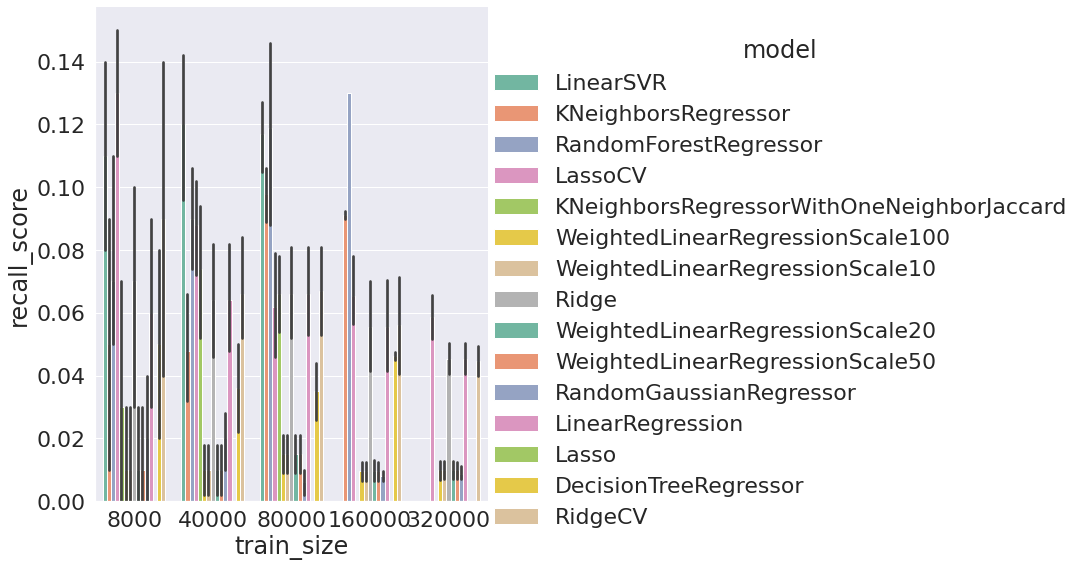

In [17]:
import seaborn as sns

sns.set(font_scale=2)
ct = sns.catplot(
    data=new_data_regressors.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (top_threshold == "Hit(top 1.0%)")'
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    #     row="top_threshold",
    #     row_order=["Hit(top 0.5%)", "Hit(top 1.0%)", "Hit(top 2.0%)", "Hit(top 5.0%)"],
    #     row="type",
    palette=sns.color_palette("Set2"),
    height=8,
    sharey=True,
    kind="bar",
)

In [14]:
all_data.loc[
    all_data.model == "WeightedLinearRegressionScale20", "model"
] = "LinearRegression, weight=20"
all_data.loc[
    all_data.model == "WeightedLinearRegressionScale50", "model"
] = "LinearRegression, weight=50"
all_data.loc[
    all_data.model == "WeightedLinearRegressionScale10", "model"
] = "LinearRegression, weight=10"
all_data.loc[
    all_data.model == "WeightedLinearRegressionScale100", "model"
] = "LinearRegression, weight=100"

In [ ]:
import seaborn as sns

sns.set(font_scale=2)
ct = sns.catplot(
    data=new_data.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (fingerprints == "Morgan")'
        " and (radius == 2)"
        " and (fps_size == 2048)"
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    col="top_threshold",
    col_order=["Hit(top 0.5%)", "Hit(top 1.0%)", "Hit(top 2.0%)", "Hit(top 5.0%)"],
    row="type",
    palette=sns.color_palette("Set2"),
    height=8,
    sharey=True,
    kind="bar",
)

## Regressors vs classifiers

In [42]:
all_data.query(
    "(train_size in [320000,  40000,   8000,  80000, 160000])"
    ' and (fingerprints == "AtomPairs")'
    #         ' and (top_threshold == "Hit(top 1.0%)")'
    #         ' and (type == "regressor")'
)

,model,type,top_threshold,train_size,true_labels,time,info,predicted_labels,accuracy_score,recall_score,precision_score,docked,fingerprints,fps_size,radius
0,WeightedLinearRegressionScale20,regressor,Hit(top 0.5%),80000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:26.936329,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9901,0.010,0.010,80100,AtomPairs,2048,-
1,WeightedLinearRegressionScale20,regressor,Hit(top 0.5%),40000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:25.834705,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9900,0.000,0.000,40050,AtomPairs,2048,-
2,WeightedLinearRegressionScale20,regressor,Hit(top 2.0%),8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:16.768823,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9600,0.000,0.000,8040,AtomPairs,2048,-
3,KNeighborsRegressorWithOneNeighborJaccard,regressor,Hit(top 1.0%),40000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:32:16.113995,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9814,0.070,0.070,40100,AtomPairs,2048,-
4,WeightedLinearRegressionScale50,regressor,Hit(top 5.0%),80000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:35.466744,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9050,0.050,0.050,81000,AtomPairs,2048,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,KNeighborsRegressorWithOneNeighborJaccard,regressor,Hit(top 2.0%),80000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 02:13:59.255484,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9638,0.095,0.095,80400,AtomPairs,2048,-
236,KNeighborsRegressorWithOneNeighborJaccard,regressor,Hit(top 2.0%),8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:01:27.463881,AP,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9610,0.025,0.025,8040,AtomPairs,2048,-
237,WeightedLinearRegressionScale10,regressor,Hit(top 0.5%),40000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:26.558104,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9900,0.000,0.000,40050,AtomPairs,2048,-
238,WeightedLinearRegressionScale10,regressor,Hit(top 1.0%),40000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 days 00:00:22.281824,AP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.9810,0.050,0.050,40100,AtomPairs,2048,-


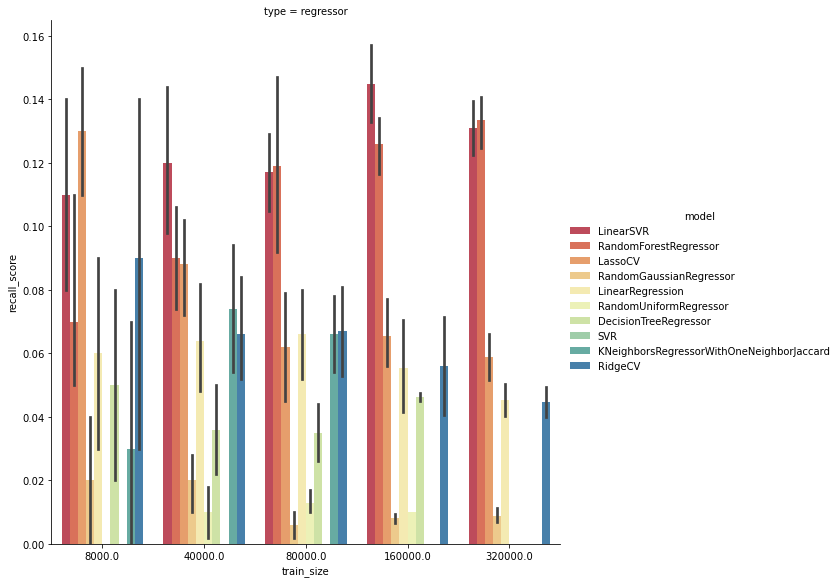

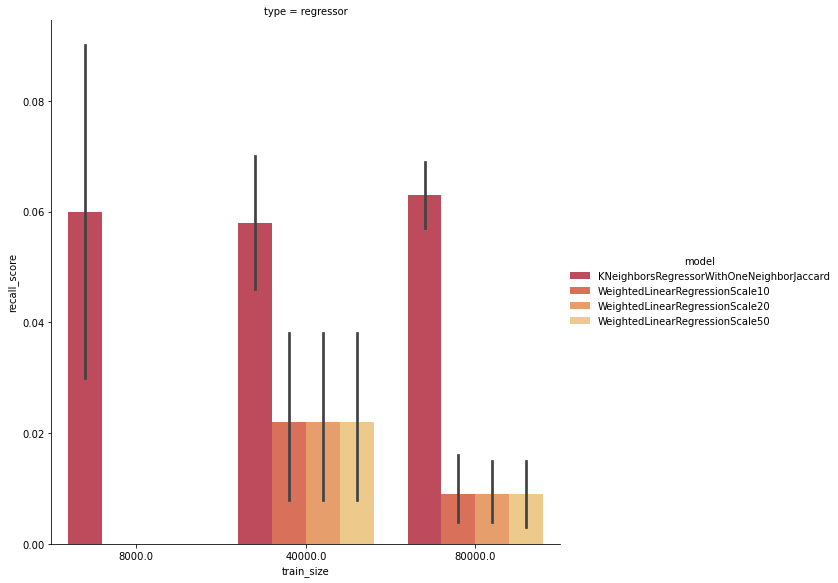

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(font_scale=2)
# ct_c = sns.catplot(
#     data=all_data.query(
#         "(train_size in [320000,  40000,   8000,  80000, 160000])"
#         ' and (fingerprints == "Morgan")'
#         " and (radius == 2)"
#         " and (fps_size == 2048)"
#         ' and (top_threshold == "Hit(top 1.0%)")'
#         ' and (type == "classifier")'
#     ),
#     x="train_size",
#     y="recall_score",
#     hue="model",
#     row="type",
#     palette=sns.color_palette("Set2"),
#     height=8,
#     sharey=True,
#     kind="bar",
# )

# plt.savefig('CvsRc.jpg', bbox_inches = 'tight')

ct_r = sns.catplot(
    data=all_data.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (fingerprints == "Morgan")'
        " and (radius == 2)"
        " and (fps_size == 2048)"
        ' and (top_threshold == "Hit(top 1.0%)")'
        ' and (type == "regressor")'
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    hue_order=[
        "LinearSVR",
        "RandomForestRegressor",
        "LassoCV",
        "RandomGaussianRegressor",
        "LinearRegression",
        "RandomUniformRegressor",
        "DecisionTreeRegressor",
        "SVR",
        "KNeighborsRegressorWithOneNeighborJaccard",
        "RidgeCV",
    ],
    row="type",
    palette=sns.color_palette("Spectral", 10),
    height=8,
    sharey=True,
    kind="bar",
)

# plt.savefig('5zty_singles.jpg', bbox_inches = 'tight')

ct_r = sns.catplot(
    data=all_data.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (fingerprints == "AtomPairs")'
        ' and (top_threshold == "Hit(top 1.0%)")'
        ' and (type == "regressor")'
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    #     hue_order=[
    #         "LinearSVR",
    #         "RandomForestRegressor",
    #         "LassoCV",
    #         "RandomGaussianRegressor",
    #         "LinearRegression",
    #         "RandomUniformRegressor",
    #         "DecisionTreeRegressor",
    #         "SVR",
    #         "KNeighborsRegressorWithOneNeighborJaccard",
    #         "RidgeCV",
    #         "WeightedLinearRegressionScale10",
    #     ],
    row="type",
    palette=sns.color_palette("Spectral", 10),
    height=8,
    sharey=True,
    kind="bar",
)


# plt.savefig('CvsRr.jpg', bbox_inches = 'tight')

## Morgan, radius = 2, size = 2048

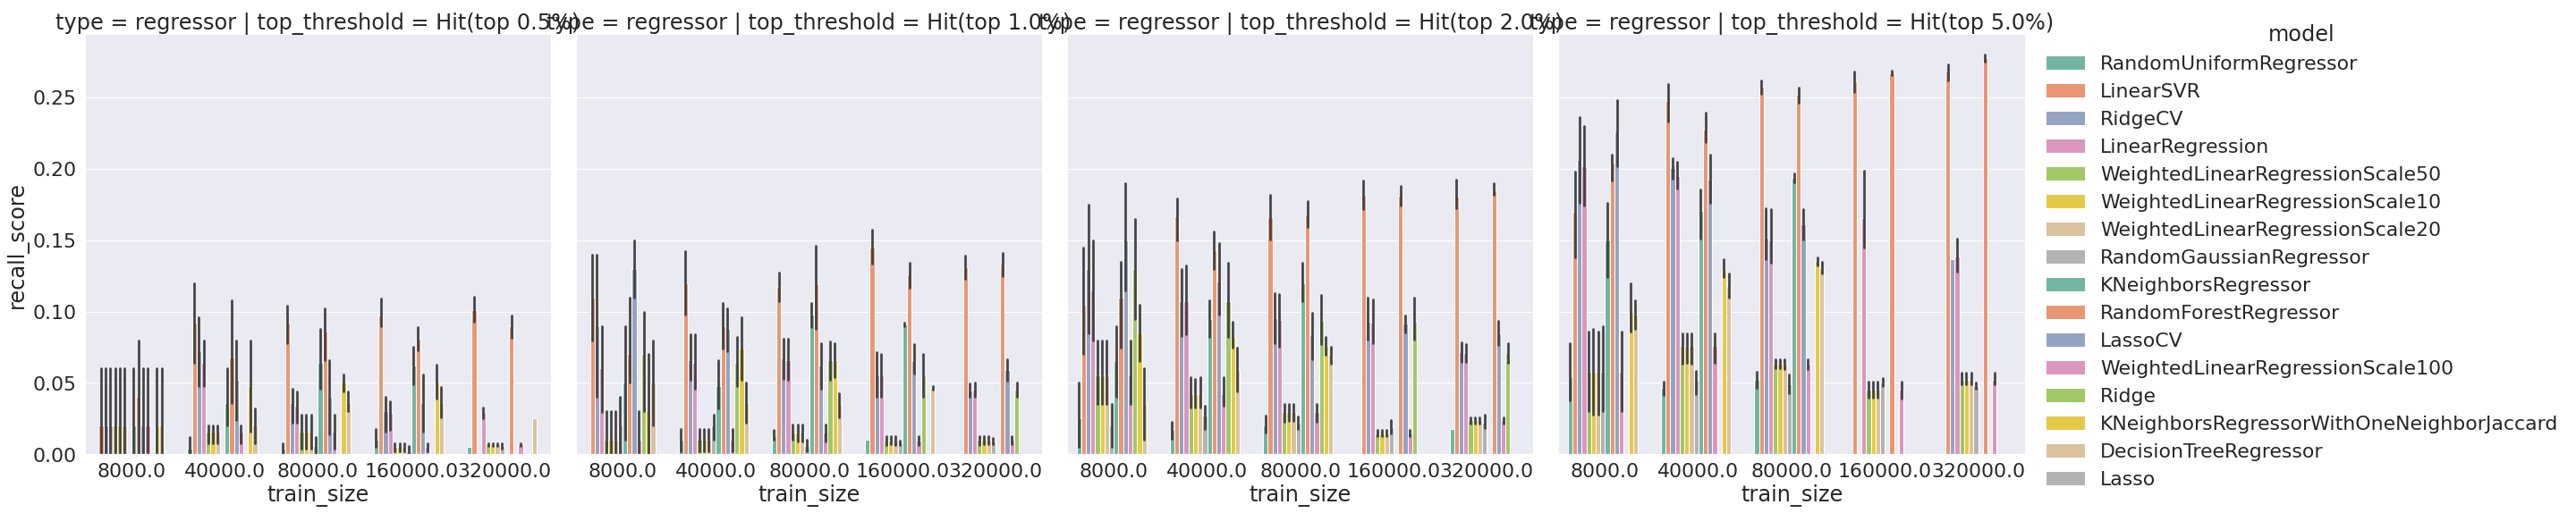

In [23]:
import seaborn as sns

sns.set(font_scale=2)
ct = sns.catplot(
    data=all_data.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (fingerprints == "Morgan")'
        " and (radius == 2)"
        " and (fps_size == 2048)"
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    col="top_threshold",
    col_order=["Hit(top 0.5%)", "Hit(top 1.0%)", "Hit(top 2.0%)", "Hit(top 5.0%)"],
    row="type",
    palette=sns.color_palette("Set2"),
    height=8,
    sharey=True,
    kind="bar",
)

## AP vs Morgan

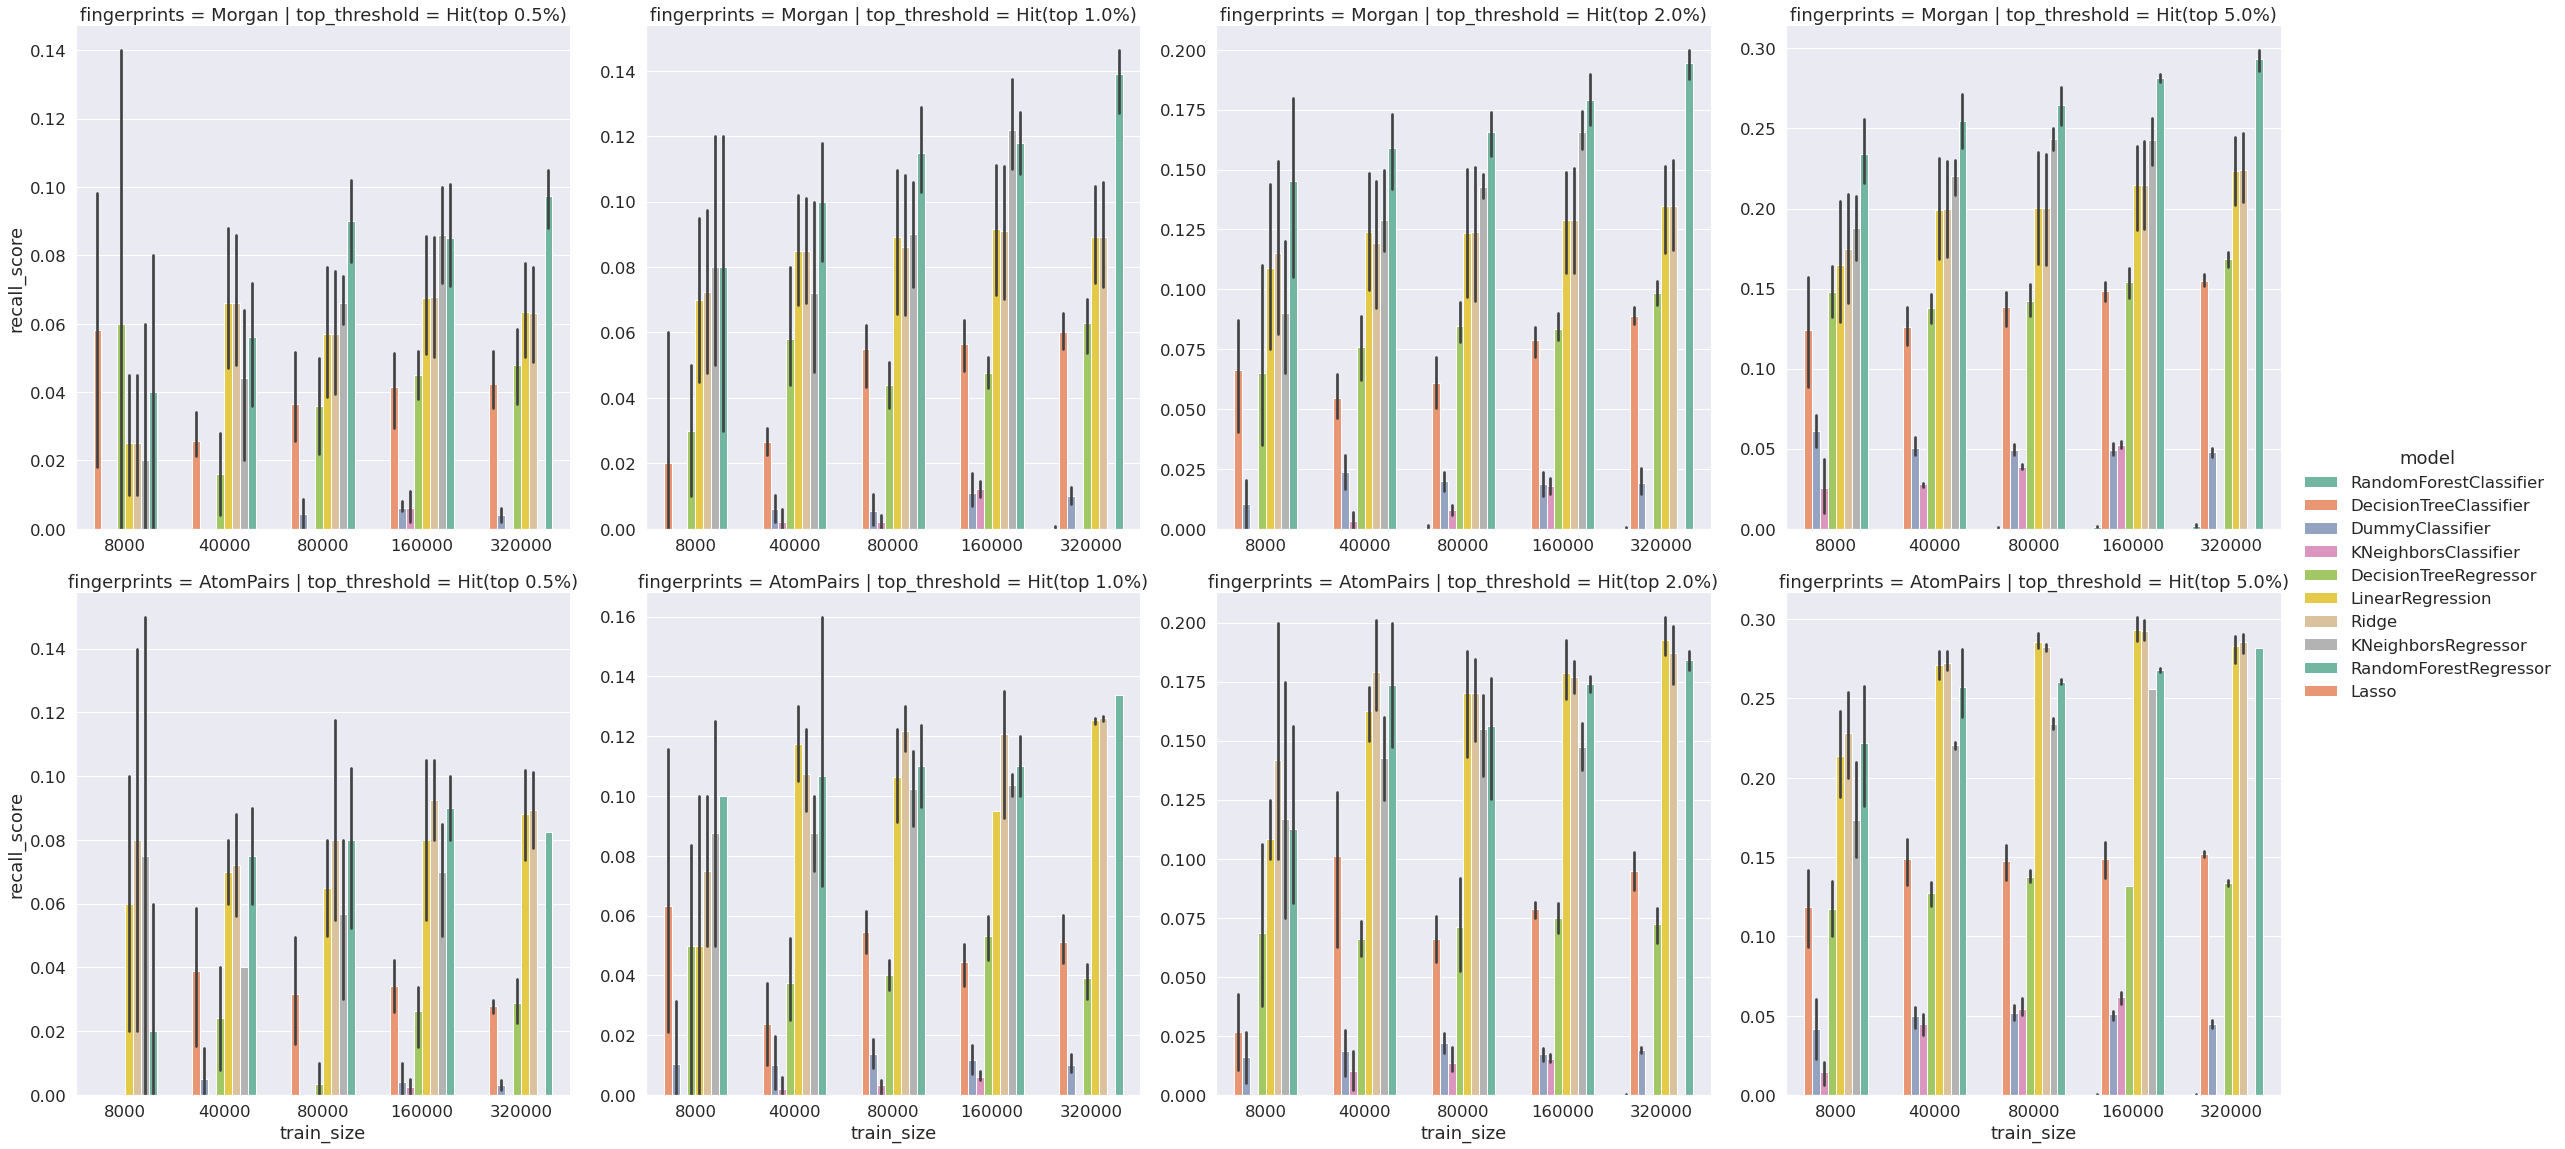

In [20]:
import seaborn as sns

sns.set(font_scale=1.5)
ct = sns.catplot(
    data=all_data.query("train_size in [320000,  40000,   8000,  80000, 160000]"),
    x="train_size",
    y="recall_score",
    hue="model",
    hue_order=list(all_data.query('fingerprints == "AtomPairs"').model.unique()),
    col="top_threshold",
    col_order=["Hit(top 0.5%)", "Hit(top 1.0%)", "Hit(top 2.0%)", "Hit(top 5.0%)"],
    row="fingerprints",
    kind="bar",
    palette=sns.color_palette("Set2"),
    height=8,
    sharey=False,
    sharex=False,
)

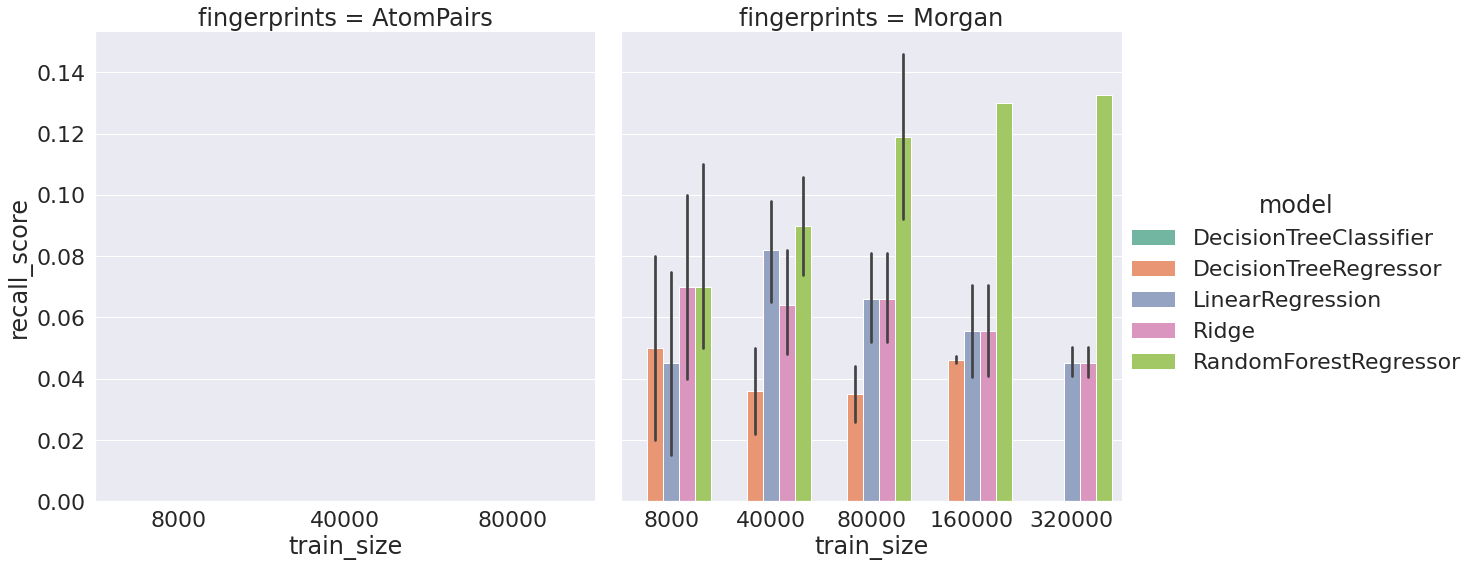

In [26]:
from matplotlib import pyplot as plt

ct = sns.catplot(
    data=all_data.query(
        "(train_size in [320000,  40000,   8000,  80000, 160000])"
        ' and (top_threshold == "Hit(top 1.0%)")'
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    hue_order=[
        "DecisionTreeClassifier",
        "DecisionTreeRegressor",
        "LinearRegression",
        "Ridge",
        "RandomForestRegressor",
    ],
    col="fingerprints",
    kind="bar",
    palette=sns.color_palette("Set2"),
    height=8,
    sharey=True,
    sharex=False,
)


plt.savefig("MorganVSAtomPairs.jpg")

## Different sizes and radiuses

In [ ]:
A = all_data.radius.values
B = all_data.fps_size.values

all_data["radius_and_size"] = list(zip(A, B))

In [ ]:
all_data["radius_and_size"].unique()

In [ ]:
import seaborn as sns

sns.set(font_scale=2)

ct = sns.catplot(
    data=all_data.query(
        '(top_threshold == "Hit(top 1.0%)") and (fingerprints == "Morgan")'
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    hue_order=[
        "LinearRegression",
        "LinearRegression, weight=10",
        "LinearRegression, weight=20",
        "LinearRegression, weight=50",
        "Ridge",
    ],
    col="radius_and_size",
    kind="bar",
    palette=sns.color_palette("colorblind"),
    height=8,
    sharey=True,
)

ct.fig.suptitle(f"Morgan fingerprints with different sizes and radiuses \n")
ct.fig.subplots_adjust(top=0.85, wspace=0.2, hspace=0.3)

plt.savefig("Different_Morgan.jpg")

In [ ]:
all_data.query("fps_size == 4096").model.unique()

## Linear regression vs docking

In [ ]:
import seaborn as sns

sns.set(font_scale=2)

ct = sns.catplot(
    data=all_data.query(
        '(top_threshold == "Hit(top 1.0%)")'
        ' and (fingerprints == "Morgan")'
        " and (radius == 2)"
        " and (fps_size == 2048)"
    ),
    x="train_size",
    y="recall_score",
    hue="model",
    hue_order=[
        "LinearRegression",
        "LinearRegression, weight=10",
        "LinearRegression, weight=20",
        "LinearRegression, weight=50",
        "DockingAsPredictor",
    ],
    kind="bar",
    palette=sns.color_palette("Spectral", 5),
    height=8,
    sharey=True,
)

# ct.fig.suptitle(f"Morgan fingerprints with different sizes and radiuses \n"
# )
ct.fig.subplots_adjust(top=0.85, wspace=0.2, hspace=0.3)

plt.savefig("Different_Morgan.jpg")

In [ ]:
all_data.model.unique()


# Iterations

## Reading iterations from json

In [247]:
def read_from_json_iterations(filename):
    import json

    with open(filename) as fin:
        d = json.load(fin)
        #         pred_single = d['predictions_single_model']
        pred_full = d["predictions_full_model"]
        yv = d["true_labels"]
    #         time = d['time_for_predictions']
    #         top_score_val = d['top_score_val']
    #         true_and_pred_score = d['true_and_pred_score']

    #     return pred_single, pred_full, yv, time, top_score_val, true_and_pred_score
    return pred_full, yv

In [248]:
@loggg(with_dataframe=False)
def predictions_from_folder_iterations(path, pdb):

    import pandas as pd
    import os
    import datetime as dt

    d = {
        "model": [],
        "type": [],
        "prediction_method": [],
        "top_threshold": [],
        "tot_num_of_iterations": [],
        "iteration": [],
        "add_to_train": [],
        "train_size": [],
        #         "pred_single": [],
        "pred_full": [],
        "true_labels": [],
        #         'time': [],
        #         "top_score_val": [],
        #         "true_and_pred_score": [],
    }

    for (
        path,
        folders,
        files,
    ) in os.walk(path):
        if path.endswith(pdb):
            for file in files:
                if (
                    ("json" in os.path.splitext(file)[1])
                    #                     and (
                    #                         ("seed=9" in os.path.splitext(file)[0])
                    #                         or ("seed=10" in os.path.splitext(file)[0])
                    #                         or ("seed=10" in os.path.splitext(file)[0])
                    #                         or ("seed=10" in os.path.splitext(file)[0])
                    #                     )
                    and ("idx" in os.path.splitext(file)[0])
                    and ("col=Hit(top 1.0%)" in os.path.splitext(file)[0])
                    #                     and (
                    #                             ("model=DockingAsPredictor" in os.path.splitext(file)[0])
                    #                             or ("model=LinearRegression" in os.path.splitext(file)[0])
                    #                             or ("model=RandomGaussianRegressor" in os.path.splitext(file)[0])
                    #                     )
                    and ("iterations=30" in os.path.splitext(file)[0])
                ):
                    print(file)

                    # 0                         'model=LinearRegression
                    # 1                         _predictionmethod=TopFromEveryModel_
                    # 2                         trainsize=80000_
                    # 3                         col=Hit(top 1.0%)_
                    # 4                         iterations=3_
                    # 5                         noadd_
                    # 6                         idx=2
                    # 7                         seed=9.json'
                    (
                        #                         pred_single,
                        pred_full,
                        yv,
                        #                         time,
                        #                         top_score_val,
                        #                         true_and_pred_score,
                    ) = read_from_json_iterations(f"{path}/{file}")

                    #                     file = file.replace("CV_every_time", "CVEveryTime")

                    model_name = file.split("_")[0].split("=")[1]
                    # More universal way to split regressors & classifiers is needed
                    if model_name.find("Classifier") == -1:
                        d["type"].append("regressor")
                    else:
                        d["type"].append("classifier")
                    d["model"].append(model_name)

                    d["prediction_method"].append(file.split("_")[1].split("=")[1])
                    d["top_threshold"].append(file.split("_")[3].split("=")[1])

                    add_to_train = file.split("_")[5]
                    d["add_to_train"].append(add_to_train)

                    d["tot_num_of_iterations"].append(
                        int(file.split("_")[4].split("=")[1])
                    )
                    iteration = int(file.split("_")[6].split("=")[1])
                    d["iteration"].append(iteration)

                    train = int(file.split("_")[2].split("=")[1])

                    d["train_size"].append(train * (1 + iteration))
                    #                         if add_to_train == 'add':
                    #                             d['train_size'].append(train * (1 + iteration))
                    #                         else:
                    #                             d['train_size'].append(train)

                    #                     d["pred_single"].append(pred_single)
                    d["pred_full"].append(pred_full)
                    d["true_labels"].append(yv)
    #                     d["time"].append(
    #                         dt.timedelta(
    #                             days=time[0], seconds=time[1], microseconds=time[2]
    #                         )
    #                     )
    #                     d["top_score_val"].append(top_score_val)
    #                     d["true_and_pred_score"].append(true_and_pred_score)

    #     models = sorted(set(d['model']))
    #     train_sizes = sorted([int(size) for size in set(d['train_size'])])
    #     columns = set(d['top_threshold'])

    df = pd.DataFrame(d)

    return df

In [258]:
@loggg(with_dataframe=True)
def calc_median_score(a):
    import numpy as np

    scores = np.array(
        [
            np.median([x[0] for x in zip(row.true_labels, row.pred_full) if x[1] == 1])
            for _, row in a.iterrows()
        ]
    )
    true_scores = np.array(
        [
            np.median([x[0] for x in zip(row.true_labels, row.pred_full)])
            for _, row in a.iterrows()
        ]
    )

    #     for _, row in a.iterrows():

    #             score = np.median(sorted([x[0] for x in zip(row.true_labels, row.pred_full) if x[1] == 1]))
    #             scores.append(score)

    #             true_score = np.median(sorted([x[0] for x in zip(row.true_labels, row.pred_full)]))
    #             true_scores.append(true_score)

    a["score"] = scores
    a["dock_score"] = true_scores
    return a

In [250]:
paths_iterations = "/storage/score_prediction_KM/2021-04-14_iterations/Morgan_radius=2_size=2048_iterations_uncut/"

In [253]:
df_iterations = predictions_from_folder_iterations(paths_iterations, pdb="4eiy")
#                                           .rename(columns = {'pred_full': 'predicted_labels'})
#                                           .pipe(calc_median_score)
#                                          )

model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=15_seed=9.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=1_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=9_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=27_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=8_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=14_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=8_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=16_se

model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=4_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=13_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=13_seed=12.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=16_seed=10.json
model=DockingAsPredictor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=17_seed=9.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=1_seed=12.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=27_seed=9.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx

model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=28_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=11_seed=11.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=19_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=20_seed=12.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=29_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=23_seed=11.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=29_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=24_seed=11.json


model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=22_seed=12.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=19_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=24_seed=12.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=14_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=7_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=19_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=13_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_n

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=25_seed=9.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=18_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=11_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=16_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=24_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=17_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=23_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=6_seed=12.json
model=LinearR

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=16_seed=9.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=27_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=25_seed=12.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=14_seed=9.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=7_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=1_seed=12.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=3_seed=12.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=15_seed=10.json
m

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=14_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=21_seed=9.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=28_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=11_seed=12.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=25_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=13_seed=11.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=7_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_no

model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=3_seed=11.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=8_seed=12.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=23_seed=10.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=27_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=26_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=9_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=0_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=22_

model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=16_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=28_seed=9.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=29_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=7_seed=9.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=11_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=29_seed=10.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=12_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=13_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=4_seed=12.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=3_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=4_seed=9.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=5_seed=11.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=15_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=3_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=2_seed=12

model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=3_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=23_seed=11.json
model=DockingAsPredictor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=8_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=5_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=16_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=1_seed=10.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=7_seed=12.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=12_seed=10.json
model=LinearR

model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=12_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=22_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=19_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=17_seed=9.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=19_seed=12.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=22_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=23_seed=12.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=9_seed=11.json
mod

model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=29_seed=12.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=20_seed=11.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=8_seed=11.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=13_seed=9.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=10_seed=9.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=0_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=14_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=20_

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=21_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=10_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=5_seed=11.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=14_seed=12.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=18_seed=9.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=13_seed=11.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=17_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=29_seed=11.

model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=6_seed=12.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=28_seed=11.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=4_seed=12.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=4_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=8_seed=11.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=17_seed=12.json
model=RandomGaussianRegressor_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=9_seed=10.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=16_seed=9

model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=14_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=16_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=28_seed=9.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=2_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=22_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=6_seed=11.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=27_seed=11.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=2_

model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=9_seed=11.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=15_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=21_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=3_seed=12.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=6_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=0_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=27_seed=12.json
model=DockingAsPredictor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=28_seed=9.json
mo

model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=23_seed=9.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=28_seed=12.json
model=RandomGaussianRegressor_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=19_seed=10.json
model=LinearRegression_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=10_seed=10.json
model=RandomGaussianRegressor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=27_seed=10.json
model=DockingAsPredictor_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_idx=22_seed=9.json
model=LinearRegression_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=24_seed=10.json
model=LinearRegression_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_idx=25_seed=9.json

In [259]:
df_iterations = calc_median_score(df_iterations)


calc_median_score,  shape (1166, 14)->(1166, 14),  took=0:02:32.202672


In [256]:
df_iterations


,model,type,prediction_method,top_threshold,tot_num_of_iterations,iteration,add_to_train,train_size,pred_full,true_labels,scores,dock_scores
0,RandomGaussianRegressor,regressor,TopFromEveryModel,Hit(top 1.0%),30,15,noadd,128000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-8.704536000000001, -20.258349, -19.498449, -...",-7.267459,-7.321810
1,LinearRegression,regressor,LastModel,Hit(top 1.0%),30,1,add,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-8.704536000000001, -20.258349, -19.498449, -...",-13.486672,-7.298553
2,RandomGaussianRegressor,regressor,LastModel,Hit(top 1.0%),30,9,noadd,80000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-11.056766, -10.909347, -17.953885, -26.00258...",-7.358333,-7.318974
3,LinearRegression,regressor,LastModel,Hit(top 1.0%),30,27,add,224000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.627088, 1.160369, -3.614036, 30.581133, -18...",-11.010688,-5.372751
4,LinearRegression,regressor,TopFromEveryModel,Hit(top 1.0%),30,8,add,72000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-11.056766, -10.909347, -17.953885, -26.00258...",-13.911192,-6.889824
...,...,...,...,...,...,...,...,...,...,...,...,...
1161,LinearRegression,regressor,LastModel,Hit(top 1.0%),30,7,add,64000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-10.028905, -9.992335, -11.911783999999999, -...",-15.280308,-6.763237
1162,LinearRegression,regressor,LastModel,Hit(top 1.0%),30,20,noadd,168000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-11.056766, -17.953885, -20.640214999999998, ...",-6.151328,-6.204915
1163,LinearRegression,regressor,MeanRank,Hit(top 1.0%),30,17,add,144000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-8.704536000000001, -19.498449, -12.859212, 9...",-12.733691,-6.124218
1164,LinearRegression,regressor,MeanRank,Hit(top 1.0%),30,28,add,232000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[-10.028905, -7.190312, 0.627088, 1.160369, -3...",-10.655707,-5.383419


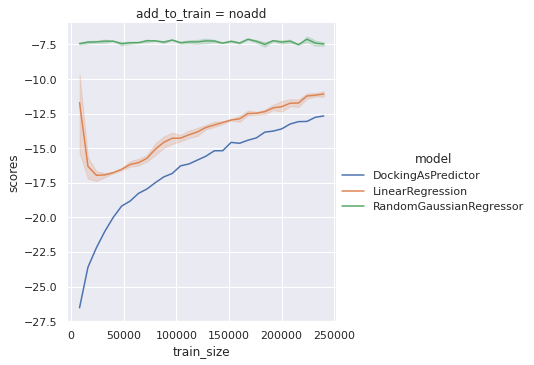

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

scat_plt = sns.relplot(
    data=df_iterations.query(
        '((model=="DockingAsPredictor") or (prediction_method=="MeanRank")) and (add_to_train=="noadd") '
    ),
    x="train_size",
    y="scores",
    hue="model",
    hue_order=["DockingAsPredictor", "LinearRegression", "RandomGaussianRegressor"],
    #     row="prediction_method",
    col="add_to_train",
    markers=True,
    dashes=False,
    kind="line",
    #                         palette=palette,
)

plt.savefig("4eiy_scores_best.jpg", bbox_inches="tight")

In [ ]:
df_iterations_full = {}
df_iterations_single = {}
df_iterations_hits = {}

for key in df_iterations.keys():
    df_iterations_full[key] = (
        df_iterations[key]
        .rename(columns={"pred_full": "predicted_labels"})
        .pipe(calc_score)
    )

    df_iterations_single[key] = (
        df_iterations[key]
        .rename(columns={"pred_single": "predicted_labels"})
        .pipe(calc_score)
    )

#     df_iterations_hits[key] = ZINC_ids_from_folder(paths_iterations[key], '4eiy')

model=LinearSVR_predictionmethod=TopFromEveryModel_trainsize=10000_col=Hit(top 1.0%)_iterations=24_noadd_seed=9.json
model=LinearSVR_predictionmethod=LastModel_trainsize=10000_col=Hit(top 1.0%)_iterations=24_noadd_seed=9.json
model=LinearSVR_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_seed=9.json
model=LinearSVR_predictionmethod=LastModel_trainsize=10000_col=Hit(top 1.0%)_iterations=24_add_seed=9.json
model=LinearSVR_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=9.json
model=LinearSVR_predictionmethod=MeanRank_trainsize=10000_col=Hit(top 1.0%)_iterations=24_noadd_seed=9.json
model=LinearSVR_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_seed=9.json
model=LinearSVR_predictionmethod=TopFromEveryModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=9.json
model=LinearSVR_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=9.json
model=Li

In [48]:
df_iterations_single["Morgan_radius=2_uncut"].query(
    '(model == "LinearRegression") and (tot_num_of_iterations == 30)'
).head

KeyboardInterrupt: 

## Full model performance

In [39]:
import matplotlib.pyplot as plt


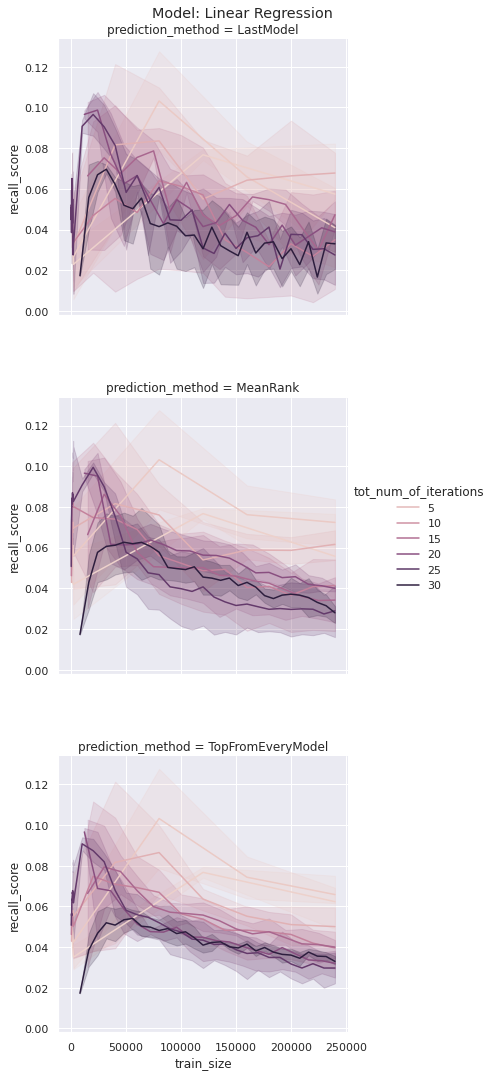

In [45]:
# palette=sns.color_palette('viridis')
sns.set(font_scale=1)
scat_plt = sns.relplot(
    data=df_iterations_full["Morgan_radius=2_uncut"].query(
        '(model == "LinearRegression")'
    ),
    #     scat_plot = sns.relplot(data=df_iterations_FullModel.loc[(df_iterations_FullModel.prediction_method == 'LastModel')
    #                                                             & (df_iterations_FullModel.add_to_train == 'add')],
    x="train_size",
    y="recall_score",
    hue="tot_num_of_iterations",
    row="prediction_method",
    markers=True,
    dashes=False,
    kind="line",
    #                         palette=palette,
)
scat_plt.fig.suptitle(f"Model: Linear Regression\n")
scat_plt.fig.subplots_adjust(top=0.95, wspace=0.2, hspace=0.3)

# line_plot = sns.relplot(data=df_iterations_TopFromEveryModel_FullModel,
#                         x="iteration",
#                         y="success",
#                         hue="tot_num_of_iterations",
#                         col='add_to_train',
#                         markers=True,
#                         dashes=False,
#                         kind='line',
#                         palette=palette,
#                        )

In [ ]:
palette = sns.color_palette(
    "viridis", n_colors=len(set(df_iterations_FullModel.tot_num_of_iterations))
)

for prediction_method in ["LastModel", "TopFromEveryModel", "MeanRank"]:
    scat_plot = sns.relplot(
        data=df_iterations_FullModel.loc[
            (df_iterations_FullModel.prediction_method == "LastModel")
            & (df_iterations_FullModel.add_to_train == "noadd")
        ],
        x="iteration",
        y="success",
        hue="tot_num_of_iterations",
        row="model",
        markers=True,
        dashes=False,
        kind="line",
        palette=palette,
    )
    scat_plot.fig.suptitle(f"Model: {prediction_method}\n")
    scat_plot.fig.subplots_adjust(top=0.95, wspace=0.2, hspace=0.3)

# line_plot = sns.relplot(data=df_iterations_TopFromEveryModel_FullModel,
#                         x="iteration",
#                         y="success",
#                         hue="tot_num_of_iterations",
#                         col='add_to_train',
#                         markers=True,
#                         dashes=False,
#                         kind='line',
#                         palette=palette,
#                        )

In [ ]:
val_plot = sns.relplot(
    data=df_iterations_full.query('model == "LinearRegression"'),
    x="train_size",
    y="top_score_val",
    hue="tot_num_of_iterations",
    col="add_to_train",
    row="prediction_method",
    markers=True,
    dashes=False,
    kind="line",
    palette=palette,
)

val_plot.fig.suptitle(f"Prediction method: {prediction_method}\n")
val_plot.fig.subplots_adjust(top=0.95, wspace=0.2, hspace=0.3)

In [ ]:
for prediction_method in ["LastModel", "TopFromEveryModel", "MeanRank"]:
    val_plot = sns.relplot(
        data=df_iterations_FullModel.loc[
            (df_iterations_FullModel.prediction_method == prediction_method)
            & (df_iterations_FullModel.add_to_train == "noadd")
        ],
        x=df_iterations_FullModel.train_size * (df_iterations_FullModel.iteration + 1),
        y="top_score_val",
        hue="tot_num_of_iterations",
        #                             col='add_to_train',
        col="model",
        markers=True,
        dashes=False,
        kind="line",
        palette=palette,
    )

    val_plot.fig.suptitle(f"Prediction method: {prediction_method}\n")
    val_plot.fig.subplots_adjust(top=0.95, wspace=0.2, hspace=0.3)

## Single model performance (TopFromEveryModel)

In [46]:
palette = sns.color_palette(
    "viridis",
    n_colors=len(
        set(df_iterations_single["Morgan_radius=2_uncut"].tot_num_of_iterations)
    ),
)

for prediction_method in ["LastModel", "TopFromEveryModel", "MeanRank"]:
    line_plot = sns.relplot(
        data=df_iterations_single["Morgan_radius=2_uncut"].loc[
            df_iterations_single["Morgan_radius=2_uncut"].prediction_method
            == prediction_method
        ],
        x="iteration",
        y="re",
        hue="tot_num_of_iterations",
        row="model",
        col="add_to_train",
        markers=True,
        dashes=False,
        kind="line",
        palette=palette,
    )

ValueError: Could not interpret value `success` for parameter `y`

In [ ]:
for prediction_method in ["LastModel", "TopFromEveryModel", "MeanRank"]:
    scat_plot = sns.relplot(
        data=df_iterations_TopFromEveryModel_FullModel.loc[
            df_iterations_TopFromEveryModel_FullModel.add_to_train == "add"
        ],
        x="train_size",
        y="top_score_val",
        hue="tot_num_of_iterations",
        col="add_to_train",
        #                         row = 'prediction_method',
        markers=True,
        dashes=False,
        kind="line",
        palette=palette,
    )

## Number of hits

In [105]:
@loggg(with_dataframe=False)
def ZINC_ids_from_folder(path, pdb):

    import pandas as pd
    import os
    import datetime as dt
    import json

    d = {
        "model": [],
        "type": [],
        "iteration": [],
        "prediction_method": [],
        #         'top_threshold':[],
        "tot_num_of_iterations": [],
        "add_to_train": [],
        "docked_size": [],
        "percentage_of_hits": [],
        "seed": [],
    }

    for (
        path,
        folders,
        files,
    ) in os.walk(path):
        if path.endswith(pdb):
            for file in files:
                if ("json" in os.path.splitext(file)[1]) and (
                    "idx" not in os.path.splitext(file)[0]
                ):
                    print(file)

                    # 0                         'model=LinearRegression
                    # 1                         _predictionmethod=TopFromEveryModel_
                    # 2                         trainsize=80000_
                    # 3                         col=Hit(top 1.0%)_
                    # 4                         iterations=3_
                    # 5                         noadd_
                    # 6                         seed=27.json'

                    model_name = file.split("_")[0].split("=")[1]
                    if model_name.find("Classifier") == -1:
                        model_type = "regressor"
                    else:
                        model_type = "classifier"

                    prediction_method = file.split("_")[1].split("=")[1]
                    top_threshold = file.split("_")[3].split("=")[1]
                    add_to_train = file.split("_")[5]
                    iterations = int(file.split("_")[4].split("=")[1])
                    train = int(file.split("_")[2].split("=")[1])
                    seed = file.split("_")[6].split("=")[1].split(".")[0]
                    #                         if add_to_train == 'add':
                    #                             train_size = train*(1 + iteration)
                    #                         else:
                    #                             train_size = train
                    with open(f"{path}/{file}") as fin:
                        ZINC_ids = json.load(fin)
                    hits_num = 0
                    for idx in range(iterations + 1):
                        d["iteration"].append(idx)
                        hits_num += (
                            100
                            * len(
                                set(ZINC_ids[f"iter_{idx}"]) & set(ZINC_ids["buffer"])
                            )
                            / len(ZINC_ids["buffer"])
                        )
                        d["percentage_of_hits"].append(hits_num)
                        d["model"].append(model_name)
                        d["type"].append(model_type)
                        d["prediction_method"].append(prediction_method)
                        d["tot_num_of_iterations"].append(iterations)
                        d["add_to_train"].append(add_to_train)
                        d["docked_size"].append(train * (idx))
                        d["seed"].append(seed)

    df = pd.DataFrame(d)

    return df

In [116]:
path_iterations = "/storage/score_prediction_KM/2021-04-14_iterations/Morgan_radius=2_size=2048_iterations_uncut"
df_iterations_hits = ZINC_ids_from_folder(path_iterations, "5zty")

model=LinearSVR_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=10.json
model=LassoCV_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=9.json
model=LassoCV_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=10.json
model=RidgeCV_predictionmethod=MeanRank_trainsize=8000_col=Hit(top 1.0%)_iterations=30_add_seed=10.json
model=LinearSVR_predictionmethod=TopFromEveryModel_trainsize=10000_col=Hit(top 1.0%)_iterations=24_noadd_seed=9.json
model=RidgeCV_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=9.json
model=LinearSVR_predictionmethod=MeanRank_trainsize=10000_col=Hit(top 1.0%)_iterations=24_add_seed=9.json
model=LinearSVR_predictionmethod=LastModel_trainsize=10000_col=Hit(top 1.0%)_iterations=24_add_seed=11.json
model=LinearSVR_predictionmethod=LastModel_trainsize=8000_col=Hit(top 1.0%)_iterations=30_noadd_seed=11.json
model=LassoCV_predictionmethod=

In [117]:
df_iterations_hits


,model,type,iteration,prediction_method,tot_num_of_iterations,add_to_train,docked_size,percentage_of_hits,seed
0,LinearSVR,regressor,0,MeanRank,30,noadd,0,0.771350,10
1,LinearSVR,regressor,1,MeanRank,30,noadd,8000,8.677686,10
2,LinearSVR,regressor,2,MeanRank,30,noadd,16000,17.079890,10
3,LinearSVR,regressor,3,MeanRank,30,noadd,24000,24.614325,10
4,LinearSVR,regressor,4,MeanRank,30,noadd,32000,30.316804,10
...,...,...,...,...,...,...,...,...,...
1594,RidgeCV,regressor,20,MeanRank,24,add,200000,71.625344,9
1595,RidgeCV,regressor,21,MeanRank,24,add,210000,73.057851,9
1596,RidgeCV,regressor,22,MeanRank,24,add,220000,74.242424,9
1597,RidgeCV,regressor,23,MeanRank,24,add,230000,75.495868,9


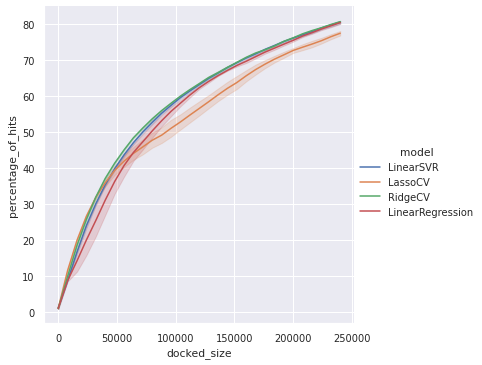

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=0.9)

p = sns.relplot(
    data=df_iterations_hits.query(
        '(tot_num_of_iterations==30) and (prediction_method=="MeanRank") and (add_to_train=="noadd")'
    ),
    x="docked_size",
    y="percentage_of_hits",
    hue="model",
    #                         col='add_to_train',
    #                         row = 'prediction_method',
    markers=True,
    dashes=False,
    kind="line",
    #                         palette=sns.color_palette("hls", 2),
)


# new_title = 'Batch size'
# p._legend.set_title(new_title)
# print(p._legend.texts)

# # new_labels = [int(240000/i) for i in [2,3,6,12,16,20,24,30]]
# new_labels = [int(240000/i) for i in [24, 30]]
# for t, l in zip(p._legend.texts, new_labels): t.set_text(l)

# p.fig.tight_layout()
plt.savefig("5ztyModelsIterations.jpg", bbox_inches="tight")

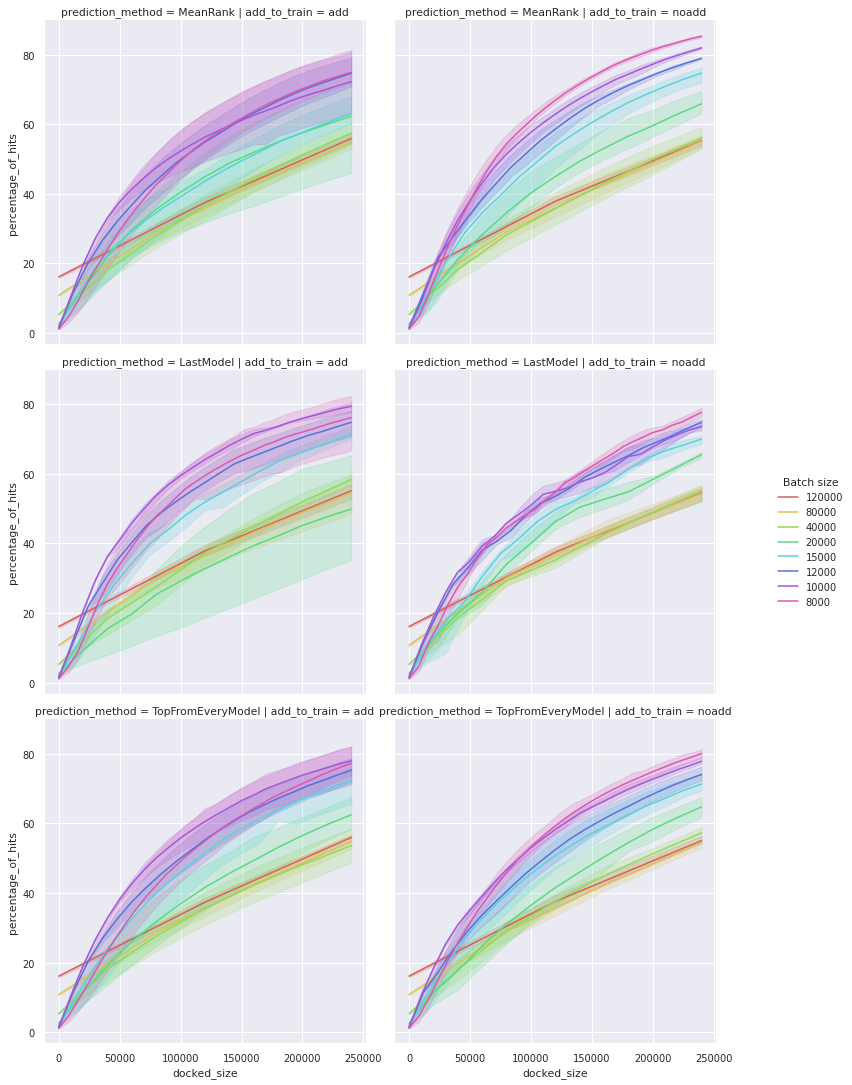

In [115]:
import seaborn as sns

sns.set(font_scale=0.9)

p = sns.relplot(
    data=df_iterations_hits.query('(model=="LinearRegression")'),
    x="docked_size",
    y="percentage_of_hits",
    hue="tot_num_of_iterations",
    col="add_to_train",
    row="prediction_method",
    markers=True,
    dashes=False,
    kind="line",
    palette=sns.color_palette("hls", 8),
)

# title
new_title = "Batch size"
p._legend.set_title(new_title)
# replace labels
new_labels = [int(240000 / i) for i in [2, 3, 6, 12, 16, 20, 24, 30]]
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

# p.fig.tight_layout()
plt.savefig("LinregIterations.jpg", bbox_inches="tight")

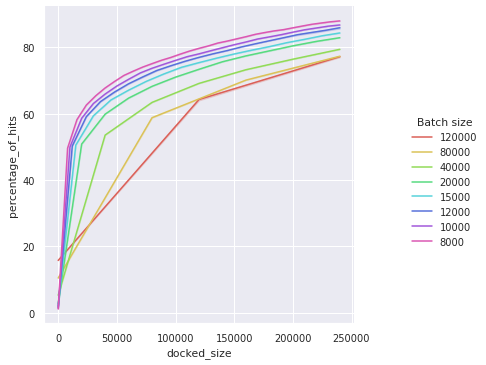

In [218]:
import seaborn as sns

sns.set(font_scale=0.9)

p = sns.relplot(
    data=df_iterations_hits.query('(model=="DockingAsPredictor")'),
    x="docked_size",
    y="percentage_of_hits",
    hue="tot_num_of_iterations",
    markers=True,
    dashes=False,
    kind="line",
    palette=sns.color_palette("hls", 8),
)

# title
new_title = "Batch size"
p._legend.set_title(new_title)
# replace labels
new_labels = [int(240000 / i) for i in [2, 3, 6, 12, 16, 20, 24, 30]]
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

# p.fig.tight_layout()
plt.savefig("4eiy_Docking_iterations.jpg", bbox_inches="tight")

## Derivative

In [93]:
def derivative(df):

    hits = df.percentage_of_hits.values
    big_hits = np.delete(hits, 0, 0)
    small_hits = np.delete(hits, -1, 0)
    hits = big_hits - small_hits

    sizes = df.docked_size.values
    sizes = np.delete(sizes, 0, 0)
    derivative = hits / sizes

    df["derivative"] = np.concatenate([[0], derivative])
    return df

In [94]:
docking = (
    df_iterations_hits.query(
        '(model == "DockingAsPredictor")'
        ' and (add_to_train == "noadd")'
        " and (tot_num_of_iterations == 30)"
    )
    .sort_values(by=["prediction_method", "seed", "iteration"])
    .pipe(derivative)
)

docking["Model"] = "Molecular docking"


linreg = (
    df_iterations_hits.query(
        '(model == "LinearRegression")'
        ' and (add_to_train == "noadd")'
        ' and (prediction_method == "MeanRank")'
        " and (tot_num_of_iterations == 30)"
    )
    .sort_values(by=["prediction_method", "seed", "iteration"])
    .pipe(derivative)
)

linreg["Model"] = "Linear Regression"


random = (
    df_iterations_hits.query(
        '(model == "RandomGaussianRegressor")'
        ' and (add_to_train == "noadd")'
        ' and (prediction_method == "MeanRank")'
        " and (tot_num_of_iterations == 30)"
    )
    .sort_values(by=["prediction_method", "seed", "iteration"])
    .pipe(derivative)
)

random["Model"] = "Random Gaussian Regressor"


data = pd.concat((docking, linreg, random))


<ipython-input-93-fa81701accbf>:10: RuntimeWarning: divide by zero encountered in true_divide
  derivative = hits/sizes


In [240]:
data["log(derivative)"] = np.log(data.derivative)

/opt/conda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


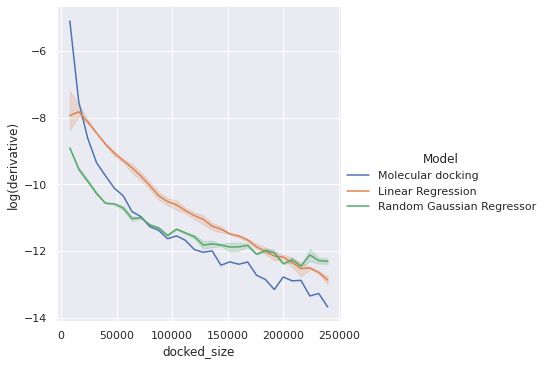

In [245]:
import seaborn as sns

sns.set(font_scale=1)

p = sns.relplot(
    data=data,
    x="docked_size",
    y="log(derivative)",
    hue="Model",
    #     palette=sns.color_palette("hls", 3),
    kind="line",
)

# # title
# new_title = "Batch size"
# p._legend.set_title(new_title)
# # replace labels
# new_labels = [int(240000 / i) for i in [2, 3, 6, 12, 16, 20, 24, 30]]
# for t, l in zip(p._legend.texts, new_labels):
#     t.set_text(l)

# # p.fig.tight_layout()
plt.savefig("4eiy_derivative.jpg", bbox_inches="tight")

In [2]:
import seaborn as sns


In [1]:
sns.set(font_scale=1.2)

p = sns.relplot(
    data=data,
    x="docked_size",
    y="percentage_of_hits",
    hue="Model",
    #     palette=sns.color_palette("hls", 3),
    kind="line",
)

p.fig.suptitle(f'Method "MeanRank", "noadd", 30 iterations')
p.fig.subplots_adjust(top=0.90)

plt.savefig("4eiy_percentage_of_hits.jpg", bbox_inches="tight")

NameError: name 'sns' is not defined